## Predicting tweet sentiments

### 1.0 Problem Statement

You work in an event management company. On Mother's Day, your company has organized an event where they want to cast positive Mother's Day related tweets in a presentation. Data engineers have already collected the data related to Mother's Day that must be categorized into positive, negative, and neutral tweets.

You are appointed as a Machine Learning Engineer for this project. Your task is to build a model that helps the company classify these sentiments of the tweets into positive, negative, and neutral.

![image.png](attachment:image.png)

#### 2.0 Importing required library

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer 
from gensim.models import Word2Vec, KeyedVectors 

import nltk
from nltk.stem import PorterStemmer 
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize 

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit 

from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, roc_curve, auc,classification_report
from sklearn.model_selection import cross_val_score 

from sklearn import preprocessing
import os
import math

import warnings
warnings.filterwarnings('ignore')

### 3.0 Loading Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
train_original = pd.read_csv('/content/drive/My Drive/HackerEarth_Tweet_Analysis/train_tweet.csv')
test_original = pd.read_csv('/content/drive/My Drive/HackerEarth_Tweet_Analysis/test_tweet.csv')

In [4]:
train = train_original.copy()
test = test_original.copy()

In [5]:
print(f"Shape of Train Data : {train.shape}\nShape of Test Data : {test.shape}")

Shape of Train Data : (3235, 6)
Shape of Test Data : (1387, 5)


In [11]:
train.head()

,id,original_text,lang,retweet_count,original_author,sentiment_class
0,1.245025e+18,Happy #MothersDay to all you amazing mothers o...,en,0,BeenXXPired,0
1,1.245759e+18,Happy Mothers Day Mum - I'm sorry I can't be t...,en,1,FestiveFeeling,0
2,1.246087e+18,Happy mothers day To all This doing a mothers ...,en,0,KrisAllenSak,-1
3,1.244803e+18,Happy mothers day to this beautiful woman...ro...,en,0,Queenuchee,0
4,1.244876e+18,Remembering the 3 most amazing ladies who made...,en,0,brittan17446794,-1


### 4.0 Exploratory Data Analysis

In [ ]:
import pandas_profiling
profile = pandas_profiling.ProfileReport(train, title='Pandas Profiling Report For Train Dataset', html={'style':{'full_width':True}})
profile

In [6]:
train_tweet = np.asarray(list(train['original_text']))
test_tweet = np.asarray(list(test['original_text']))

In [7]:
type(train_tweet)

numpy.ndarray

## 5.0 Text_Preprocessing

## 5.1 Removing Stop words and other html tag

In [22]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [23]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [24]:
from tqdm import tqdm
preprocessed_tweets = []
# tqdm is for printing the status bar
for sentance in tqdm(train_tweet):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_tweets.append(sentance.strip())

100%|██████████| 3235/3235 [00:00<00:00, 3939.20it/s]


In [25]:
train_tweet = preprocessed_tweets

In [26]:
train_tweet[0]

'happy mothersday amazing mothers know hard not able see mothers today us protect vulnerable members society beatcoronavirus'

In [27]:
from tqdm import tqdm
preprocessed_tweets = []
# tqdm is for printing the status bar
for sentance in tqdm(test_tweet):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_tweets.append(sentance.strip())

100%|██████████| 1387/1387 [00:00<00:00, 3513.87it/s]


In [28]:
test_tweet[0]

'yeah cooked potatoes years old mean threw bag spuds toilet happy mothers day made breakfast time thought cool drawing naked lady dachshund overhead projector psychology class'

In [29]:
test_tweet = preprocessed_tweets

In [30]:
test_tweet[0]

'yeah cooked potatoes years old mean threw bag spuds toilet happy mothers day made breakfast time thought cool drawing naked lady dachshund overhead projector psychology class'

## 5.2 Word2Vec

In [31]:
list_of_Train_sent=[]
list_of_Test_sent=[]

for sent in train_tweet:
    list_of_Train_sent.append(sent.split())
    
for sent in test_tweet:
    list_of_Test_sent.append(sent.split())

In [33]:
# Using Google Trained W2V 

w2v_model=KeyedVectors.load_word2vec_format('/content/drive/My Drive/AmazonFineFoodReviews/GoogleNews-vectors-negative300.bin', binary=True)


In [34]:
import numpy as np

Train_vectors = []
for sent in list_of_Train_sent:
    sent_vec = np.zeros(300)
    cnt_words = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    if cnt_words!=0:    
        sent_vec /= cnt_words
    Train_vectors.append(sent_vec)
Train_vectors = np.nan_to_num(Train_vectors)

print("Shape of Train Vectors : ",Train_vectors.shape)

Shape of Train Vectors :  (3235, 300)


In [35]:
Test_vectors=[]
for sent in list_of_Test_sent:
    sent_vec=np.zeros(300)
    cnt_words=0
    for word in sent:
        try:
            vec=w2v_model.wv[word]
            sent_vec+=vec
            cnt_words+=1
        except:
            pass
    if cnt_words!=0:
        sent_vec/=cnt_words
    Test_vectors.append(sent_vec)
Test_vectors=np.nan_to_num(Test_vectors)   

print("Shape of Test Vectors : ",Test_vectors.shape)

Shape of Test Vectors :  (1387, 300)


In [36]:
train_tweet_av_w2v = Train_vectors
test_tweet_av_w2v = Test_vectors

## 5.3 TF-IDF Word2Vec

In [39]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(train_tweet)

X_train_tfidf = model.transform(train_tweet)
X_test_tfidf = model.transform(test_tweet)

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [40]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3000000
sample words  ['</s>', 'in', 'for', 'that', 'is', 'on', '##', 'The', 'with', 'said', 'was', 'the', 'at', 'not', 'as', 'it', 'be', 'from', 'by', 'are', 'I', 'have', 'he', 'will', 'has', '####', 'his', 'an', 'this', 'or', 'their', 'who', 'they', 'but', '$', 'had', 'year', 'were', 'we', 'more', '###', 'up', 'been', 'you', 'its', 'one', 'about', 'would', 'which', 'out']


In [41]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

train_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_Train_sent): # for each review/sentence 
    sent_vec = np.zeros(300) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    train_tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 3235/3235 [12:02<00:00,  4.48it/s]


In [42]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

test_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_Test_sent): # for each review/sentence 
    sent_vec = np.zeros(300) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    test_tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 1387/1387 [05:05<00:00,  4.54it/s]


In [43]:
train_tweet_tfidf_w2v =np.nan_to_num(train_tfidf_sent_vectors) 
test_tweet_tfidf_w2v =np.nan_to_num(test_tfidf_sent_vectors)

In [44]:
type(train_tweet_tfidf_w2v)

numpy.ndarray

In [45]:
type(train_tweet_av_w2v)

numpy.ndarray

In [46]:
train_tweet_tfidf_w2v_df = pd.DataFrame(train_tweet_tfidf_w2v)

In [47]:
train_tweet_tfidf_w2v_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0.007966,0.029122,-0.079177,0.137069,-0.126610,0.011850,0.092104,-0.009415,0.108381,0.022545,-0.003321,-0.139220,-0.011792,0.030174,-0.153961,0.071318,0.016756,0.120947,-0.042073,0.015646,0.023235,-0.041648,0.039018,-0.029399,0.063636,-0.105759,-0.008525,-0.011295,0.047714,-0.167473,0.015695,-0.017556,-0.020313,-0.025097,0.046359,-0.041369,0.051233,0.014045,0.027525,0.087983,...,-0.090317,-0.078104,-0.023593,0.061475,0.020737,0.109083,-0.025040,-0.005035,-0.125645,0.083668,-0.026925,0.168605,0.149582,0.123125,0.049370,-0.120787,0.019566,-0.103714,-0.059354,0.018510,0.049736,-0.004903,-0.015035,0.082104,-0.008810,-0.047394,-0.105800,-0.017513,0.041321,0.045696,-0.041294,0.016941,-0.129749,-0.065659,-0.117191,0.034511,-0.004357,-0.037715,0.062411,-0.080468
1,0.057854,0.049085,0.047131,0.163011,-0.050157,-0.054151,0.092920,-0.126437,0.026738,0.145180,-0.008382,-0.153857,-0.005286,0.038415,-0.019022,0.099951,0.039274,0.042621,0.017833,-0.154465,0.039526,0.022996,0.098413,-0.056485,0.023255,-0.023541,-0.078820,0.027836,0.020635,-0.118854,-0.040743,0.079551,-0.074944,-0.079314,-0.015892,-0.077524,0.069138,0.013882,-0.008088,0.030896,...,-0.049849,-0.095876,-0.055006,0.043596,0.041251,0.098682,0.002203,0.041623,-0.064354,-0.009484,0.054957,0.141265,0.175365,0.071853,0.080741,-0.077519,0.004045,-0.099451,-0.076308,0.053711,0.055806,0.003566,0.037376,0.088948,0.028169,-0.030901,-0.057205,0.046978,0.022857,0.089828,-0.030169,0.052993,-0.070600,0.056155,-0.012739,-0.011594,-0.009400,-0.079979,-0.005705,-0.044016
2,-0.022229,0.022335,-0.016421,0.071434,-0.036472,-0.000640,0.084014,-0.104518,0.044398,0.067294,0.043874,-0.124178,-0.021519,0.117741,-0.021602,0.121746,0.014868,0.158765,0.088615,-0.141917,0.026191,0.122243,0.047700,0.009986,-0.018817,0.020772,-0.085795,0.041381,0.023629,-0.016024,-0.069006,0.050206,-0.051492,-0.027536,0.008035,-0.041579,0.014132,-0.051892,0.052843,0.089912,...,-0.017341,-0.034411,-0.035726,0.005779,0.026516,0.071230,-0.047363,-0.049890,-0.135919,-0.014633,-0.002929,0.079278,0.085736,0.101363,0.099642,-0.020334,-0.066505,-0.085502,-0.079076,0.021282,0.037891,-0.049335,0.040352,0.029739,0.016216,-0.062886,-0.112769,0.032567,-0.018905,0.128366,-0.000791,0.071119,-0.081494,-0.021682,-0.031754,-0.052603,-0.000597,0.007411,0.072968,0.025507
3,0.007025,0.083517,-0.002529,0.093093,0.041671,0.061974,0.092553,-0.185029,-0.016474,0.122303,-0.192012,-0.267267,-0.017497,0.088500,-0.021342,0.139608,-0.091804,0.154518,0.002973,0.016526,-0.088173,0.036078,0.039547,-0.062223,-0.075548,-0.040663,-0.174186,0.049888,0.053359,-0.154768,0.084329,-0.000051,-0.083806,0.009882,-0.073820,-0.092775,-0.037652,-0.006710,-0.041775,0.148481,...,0.066300,0.004931,-0.071103,0.026558,0.030531,0.190126,-0.109070,-0.063236,0.040288,-0.116953,-0.059407,0.130685,-0.045969,-0.024400,0.167072,-0.018202,-0.017404,-0.023219,-0.142786,0.182199,0.071616,-0.006006,0.083823,0.098443,0.130266,-0.160450,-0.098065,-0.005216,0.078957,0.147915,-0.014652,-0.068660,-0.050499,0.002840,-0.059664,0.062083,-0.003432,-0.013626,0.079680,0.070035
4,0.043569,0.012683,0.040122,0.134913,0.036879,-0.042431,-0.005020,-0.094025,0.048218,0.094069,0.045588,-0.189556,-0.046844,0.023212,0.013414,0.057961,0.078272,0.130612,-0.032632,-0.062286,0.055316,0.107428,0.099986,-0.060364,0.059264,-0.064179,-0.111702,0.030851,0.077698,-0.096774,-0.008006,0.006166,-0.029878,0.013057,0.034960,-0.084659,0.112222,0.006651,0.001141,0.120599,...,0.017874,-0.054964,-0.019462,-0.079876,-0.015309,0.025762,-0.011473,-0.017037,-0.077019,-0.001454,0.015261,0.129322,-0.002734,0.014040,0.189133,-0.105607,0.032977,-0.072307,-0.068000,-0.027072,0.050669,-0.036076,-0.066784,0.034492,-0.017786,0.025197,-0.075114,0.095110,-0.087306,0.19

In [48]:
test_tweet_tfidf_w2v_df = pd.DataFrame(test_tweet_tfidf_w2v)

In [49]:
test_tweet_tfidf_w2v_df.shape

(1387, 300)

In [50]:
train_tweet_av_w2v_df = pd.DataFrame(train_tweet_av_w2v)
test_tweet_av_w2v_df = pd.DataFrame(test_tweet_av_w2v)

In [51]:
train_tweet_av_w2v_df.shape

(3235, 300)

In [52]:
train.shape

(3235, 6)

In [53]:
av_train = pd.concat([train, train_tweet_av_w2v_df], axis=1, sort=False)
av_test = pd.concat([test, test_tweet_av_w2v_df], axis=1, sort=False)

In [54]:
av_train.shape

(3235, 306)

In [55]:
idf_train = pd.concat([train, train_tweet_tfidf_w2v_df], axis=1, sort=False)
idf_test = pd.concat([test, test_tweet_tfidf_w2v_df], axis=1, sort=False)

In [66]:
# Saving Train dataset for Average W2V 
av_train.to_csv('/content/drive/My Drive/HackerEarth_Tweet_Analysis/av_train.csv',index=False)

In [63]:
# Saving Train dataset for Average W2V
av_test.to_csv('/content/drive/My Drive/HackerEarth_Tweet_Analysis/av_test.csv',index=False)

In [64]:
# Saving Test dataset for TF-IDF 
idf_train.to_csv('/content/drive/My Drive/HackerEarth_Tweet_Analysis/idf_train.csv',index=False)

In [65]:
# Saving Test dataset for TF-IDF 
idf_test.to_csv('/content/drive/My Drive/HackerEarth_Tweet_Analysis/idf_test.csv',index=False)

In [67]:
df = pd.read_csv('/content/drive/My Drive/HackerEarth_Tweet_Analysis/av_train.csv')

In [61]:
df.head()

,id,original_text,lang,retweet_count,original_author,sentiment_class,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,1.245025e+18,Happy #MothersDay to all you amazing mothers o...,en,0,BeenXXPired,0,0.006224,0.016652,-0.059043,0.135099,-0.084664,-0.009578,0.105659,-0.027958,0.082699,0.047298,-0.012480,-0.138745,-0.006388,0.026009,-0.144836,0.100741,0.045231,0.118700,-0.029989,0.018219,-0.005485,-0.016490,0.052775,-0.053359,0.072870,-0.087467,0.004339,-0.022965,0.049809,-0.169165,0.015145,0.001143,-0.017419,-0.036722,...,-0.084310,-0.067184,-0.029767,0.074530,0.028353,0.115963,-0.011149,-0.013070,-0.109446,0.100472,-0.013428,0.164787,0.169604,0.107927,0.055906,-0.110828,0.014182,-0.078711,-0.037185,-0.011975,0.035409,-0.012091,-0.034558,0.091072,-0.016385,-0.041573,-0.097504,-0.017164,0.032633,0.068571,-0.038704,0.030339,-0.123289,-0.075947,-0.097703,0.012557,0.000376,-0.031157,0.051605,-0.092464
1,1.245759e+18,Happy Mothers Day Mum - I'm sorry I can't be t...,en,1,FestiveFeeling,0,0.026940,0.042607,0.036109,0.164507,-0.058188,-0.053771,0.096530,-0.104744,0.028592,0.118041,0.005022,-0.143848,-0.011448,0.037653,-0.052687,0.102847,0.037148,0.074971,0.015959,-0.115681,-0.002070,0.013827,0.102293,-0.063103,0.019460,-0.041807,-0.080443,0.038232,0.031151,-0.119803,-0.022664,0.047014,-0.084083,-0.078086,...,-0.057313,-0.076269,-0.029614,0.044526,0.032258,0.096340,0.008669,0.046606,-0.067458,0.029658,0.051436,0.135063,0.185137,0.076475,0.094609,-0.079188,-0.024352,-0.071619,-0.052002,0.033557,0.047319,0.022745,0.011152,0.085464,0.028712,-0.041962,-0.056507,0.063279,0.013437,0.097190,-0.033086,0.031792,-0.090582,0.004741,-0.020702,-0.017509,-0.026230,-0.059735,0.009480,-0.045664
2,1.246087e+18,Happy mothers day To all This doing a mothers ...,en,0,KrisAllenSak,-1,-0.031640,0.034089,-0.016784,0.083834,-0.024532,-0.011336,0.084352,-0.100312,0.053271,0.074446,0.048741,-0.119109,-0.005851,0.102782,-0.027319,0.116835,0.015379,0.146882,0.079063,-0.106568,0.014148,0.101770,0.039652,-0.014061,-0.014547,0.011742,-0.058985,0.035977,0.027827,-0.036474,-0.051094,0.037979,-0.057545,-0.032626,...,-0.026047,-0.043624,-0.020033,0.021187,0.041847,0.082658,-0.034367,-0.028059,-0.135052,0.026193,0.002490,0.092477,0.104337,0.097135,0.109732,-0.042654,-0.065331,-0.068073,-0.058469,0.001473,0.039994,-0.046730,0.023955,0.048094,0.004428,-0.061081,-0.112660,0.043474,-0.015852,0.131651,-0.012594,0.066420,-0.088703,-0.032719,-0.022255,-0.050004,-0.013508,0.014339,0.066354,0.005636
3,1.244803e+18,Happy mothers day to this beautiful woman...ro...,en,0,Queenuchee,0,-0.001834,0.078931,-0.011973,0.098047,0.058740,0.018918,0.124645,-0.135352,0.025785,0.113232,-0.101465,-0.232593,0.000500,0.064771,-0.014099,0.136841,-0.069965,0.118042,-0.000098,0.031917,-0.064331,0.026169,0.050806,-0.094812,-0.032776,-0.062476,-0.110313,0.025281,0.086743,-0.182599,0.055365,0.007324,-0.066504,0.007367,...,0.026440,-0.010573,-0.047826,0.031995,0.055249,0.174609,-0.079285,-0.014357,-0.023413,-0.004883,-0.041785,0.138381,0.015869,0.021047,0.183331,-0.057007,-0.004638,-0.004553,-0.107825,0.082324,0.076978,-0.001874,0.026245,0.126685,0.089648,-0.140607,-0.081989,-0.015430,0.045871,0.155408,-0.026562,-0.029254,-0.088330,-0.047444,-0.053467,0.051636,-0.008459,-0.006471,0.068739,0.026978
4,1.244876e+18,Remembering the 3 most amazing ladies who made...,en,0,brittan17446794,-1,0.017063,0.022918,0.013375,0.133744,0.014432,-0.053335,0.014585,-0.105228,0.056391,0.099484,0.033742,-0.169414,-0.028860,0.036792,0.000654,0.104142,0.073226,0.106617,-0.014413,-0.047140,0.032235,0.092277,0.104973,-0.059542,0.045840,-0.059620,-0.090895,0.040119,0.077200,-0.101930,-0.016068,0.019444,-0.029017,-0.000742,...,-0.004167,-0.040881,0.013578,-0.040271,-0.007099,0.017845,-0.036218,-0.010160,-0.058142,0.024727,-

We have saved the csv files and now we will continue our modeling in the new notebook

## 6.0 Importing the W2V Dataset

I am training model on Average W2v because it is giving best result than TF-IDF W2V

In [68]:
train_original = pd.read_csv('/content/drive/My Drive/HackerEarth_Tweet_Analysis/av_train.csv')
test_original = pd.read_csv('/content/drive/My Drive/HackerEarth_Tweet_Analysis/av_test.csv')

In [74]:
train = train_original.copy()
test = test_original.copy()

In [75]:
print(f"Shape of Train Data : {train.shape}\nShape of Test Data : {test.shape}")

Shape of Train Data : (3235, 306)
Shape of Test Data : (1387, 305)


In [76]:
train.head(2)

,id,original_text,lang,retweet_count,original_author,sentiment_class,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,1.245025e+18,Happy #MothersDay to all you amazing mothers o...,en,0,BeenXXPired,0,0.006224,0.016652,-0.059043,0.135099,-0.084664,-0.009578,0.105659,-0.027958,0.082699,0.047298,-0.012480,-0.138745,-0.006388,0.026009,-0.144836,0.100741,0.045231,0.118700,-0.029989,0.018219,-0.005485,-0.016490,0.052775,-0.053359,0.07287,-0.087467,0.004339,-0.022965,0.049809,-0.169165,0.015145,0.001143,-0.017419,-0.036722,...,-0.084310,-0.067184,-0.029767,0.074530,0.028353,0.115963,-0.011149,-0.013070,-0.109446,0.100472,-0.013428,0.164787,0.169604,0.107927,0.055906,-0.110828,0.014182,-0.078711,-0.037185,-0.011975,0.035409,-0.012091,-0.034558,0.091072,-0.016385,-0.041573,-0.097504,-0.017164,0.032633,0.068571,-0.038704,0.030339,-0.123289,-0.075947,-0.097703,0.012557,0.000376,-0.031157,0.051605,-0.092464
1,1.245759e+18,Happy Mothers Day Mum - I'm sorry I can't be t...,en,1,FestiveFeeling,0,0.026940,0.042607,0.036109,0.164507,-0.058188,-0.053771,0.096530,-0.104744,0.028592,0.118041,0.005022,-0.143848,-0.011448,0.037653,-0.052687,0.102847,0.037148,0.074971,0.015959,-0.115681,-0.002070,0.013827,0.102293,-0.063103,0.01946,-0.041807,-0.080443,0.038232,0.031151,-0.119803,-0.022664,0.047014,-0.084083,-0.078086,...,-0.057313,-0.076269,-0.029614,0.044526,0.032258,0.096340,0.008669,0.046606,-0.067458,0.029658,0.051436,0.135063,0.185137,0.076475,0.094609,-0.079188,-0.024352,-0.071619,-0.052002,0.033557,0.047319,0.022745,0.011152,0.085464,0.028712,-0.041962,-0.056507,0.063279,0.013437,0.097190,-0.033086,0.031792,-0.090582,0.004741,-0.020702,-0.017509,-0.026230,-0.059735,0.009480,-0.045664


In [77]:
# Checking for NULL Values Column

train.isnull().mean()

id                 0.000000
original_text      0.000000
lang               0.001236
retweet_count      0.001236
original_author    0.000000
                     ...   
295                0.000000
296                0.000000
297                0.000000
298                0.000000
299                0.000000
Length: 306, dtype: float64

Column **lang** and **retweet_count** have Null Value

## 7.0 Feature Engineering

In [78]:
# Dropping ID and lang column of train dataset

train.drop(['id','lang'],axis = 1,inplace = True)
train.head(2)

,original_text,retweet_count,original_author,sentiment_class,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,Happy #MothersDay to all you amazing mothers o...,0,BeenXXPired,0,0.006224,0.016652,-0.059043,0.135099,-0.084664,-0.009578,0.105659,-0.027958,0.082699,0.047298,-0.012480,-0.138745,-0.006388,0.026009,-0.144836,0.100741,0.045231,0.118700,-0.029989,0.018219,-0.005485,-0.016490,0.052775,-0.053359,0.07287,-0.087467,0.004339,-0.022965,0.049809,-0.169165,0.015145,0.001143,-0.017419,-0.036722,0.026307,-0.012333,...,-0.084310,-0.067184,-0.029767,0.074530,0.028353,0.115963,-0.011149,-0.013070,-0.109446,0.100472,-0.013428,0.164787,0.169604,0.107927,0.055906,-0.110828,0.014182,-0.078711,-0.037185,-0.011975,0.035409,-0.012091,-0.034558,0.091072,-0.016385,-0.041573,-0.097504,-0.017164,0.032633,0.068571,-0.038704,0.030339,-0.123289,-0.075947,-0.097703,0.012557,0.000376,-0.031157,0.051605,-0.092464
1,Happy Mothers Day Mum - I'm sorry I can't be t...,1,FestiveFeeling,0,0.026940,0.042607,0.036109,0.164507,-0.058188,-0.053771,0.096530,-0.104744,0.028592,0.118041,0.005022,-0.143848,-0.011448,0.037653,-0.052687,0.102847,0.037148,0.074971,0.015959,-0.115681,-0.002070,0.013827,0.102293,-0.063103,0.01946,-0.041807,-0.080443,0.038232,0.031151,-0.119803,-0.022664,0.047014,-0.084083,-0.078086,-0.040808,-0.048383,...,-0.057313,-0.076269,-0.029614,0.044526,0.032258,0.096340,0.008669,0.046606,-0.067458,0.029658,0.051436,0.135063,0.185137,0.076475,0.094609,-0.079188,-0.024352,-0.071619,-0.052002,0.033557,0.047319,0.022745,0.011152,0.085464,0.028712,-0.041962,-0.056507,0.063279,0.013437,0.097190,-0.033086,0.031792,-0.090582,0.004741,-0.020702,-0.017509,-0.026230,-0.059735,0.009480,-0.045664


In [79]:
# Storing ID of test data to use in submission 
ID = test['id']
test.drop(['id','lang'],axis = 1,inplace = True)
test.head(2)

,original_text,retweet_count,original_author,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,"3. Yeah, I once cooked potatoes when I was 3 y...",0,LToddWood,0.014093,0.077771,0.006910,0.158078,-0.002797,-0.056234,0.064141,-0.056311,0.082318,0.103781,0.043809,-0.142156,0.032663,0.004389,-0.078942,0.095193,0.021421,0.093633,0.003578,-0.089447,0.022304,0.072204,0.040255,-0.057333,0.047006,-0.065452,-0.097392,0.108327,0.045931,-0.027886,-0.010115,0.015341,-0.012732,-0.008500,-0.012243,-0.039754,0.089438,...,-0.013145,0.013553,-0.109422,-0.015827,0.021623,0.080717,-0.002066,-0.006553,-0.088709,0.030628,-0.011061,0.058293,0.099505,0.005798,0.094651,-0.063585,-0.047641,-0.076641,-0.031750,-0.035760,0.075527,0.030182,0.024643,0.056827,-0.019360,-0.034081,-0.059392,0.064772,0.011031,0.121117,-0.106461,0.013042,-0.139965,0.01797,0.003479,-0.069661,-0.014849,0.018463,0.044505,0.028421
1,"Happy Mother's Day to all the mums, step-mums,...",0,iiarushii,-0.006758,-0.002610,-0.073644,0.114802,0.006179,-0.099365,0.091147,-0.067852,0.037112,0.085130,0.166239,-0.107713,0.067026,0.062707,-0.119122,0.169814,0.024292,0.100192,-0.001371,-0.033783,0.046077,0.000829,0.142315,-0.006423,0.032898,-0.044006,-0.117024,0.080247,0.056132,-0.117986,0.004639,0.013198,-0.074392,0.007212,-0.016982,0.000113,0.065276,...,0.011524,-0.044063,0.029271,0.035740,0.005606,0.062462,-0.190730,0.077402,-0.127629,0.041803,-0.106098,0.139547,0.087299,0.065650,0.215182,-0.048603,0.034236,0.006263,0.082491,0.017334,0.050611,-0.053105,-0.039531,0.125089,0.019832,-0.021851,-0.113298,0.066988,-0.042362,0.178636,-0.047110,0.094839,-0.079688,-0.11869,-0.091745,-0.026175,0.007075,0.060275,0.023470,-0.018172


## 7.1 Missing Value Imputation 

In [82]:
# Function to extract digit from string and convert it into integer 
# Using Train Data retweet_Column

import re
def select_number(sentence):
    #if re.search(r'\d+', sentence).group(0) == "Nana"
    return int(re.search(r'\d+', sentence).group(0))

retweet_count_cleaned = []
for value in train['retweet_count']:
    try:
        digit = select_number(value)
        retweet_count_cleaned.append(digit)
    except:
        retweet_count_cleaned.append(0)

In [83]:
train['retweet_count'] = retweet_count_cleaned

In [84]:
# Function to extract digit from string and convert it into integer 
# Using Test Data retweet_Column

retweet_count_cleaned = []
for value in test['retweet_count']:
    try:
        digit = select_number(value)
        retweet_count_cleaned.append(digit)
    except:
        retweet_count_cleaned.append(0)
    
test['retweet_count'] = retweet_count_cleaned

In [85]:
mean=train.retweet_count.mean()
median = train.retweet_count.median()
print(f'Mean : {mean}\nMedian : {median}')

Mean : 0.6692426584234931
Median : 0.0


In [89]:
X_train_Mean=train['retweet_count'].fillna(mean)
X_train_median=train['retweet_count'].fillna(median)

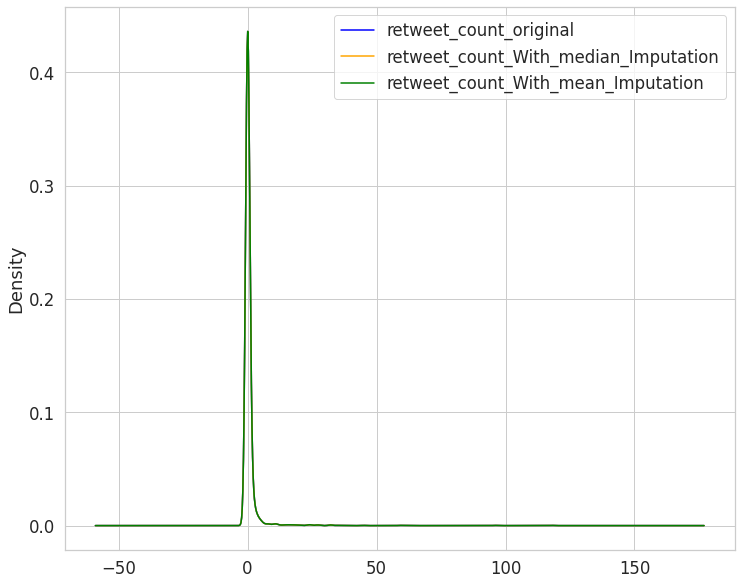

In [102]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 12,10
sns.set(style='whitegrid', palette='muted', font_scale = 1.5)

fig = plt.figure()
ax = fig.add_subplot(111)

# original variable distribution
train['retweet_count'].plot(kind='kde', ax=ax, color='blue', label='retweet_count_original')

# variable imputed with the median
X_train_median.plot(kind='kde', ax=ax, color='orange', label='retweet_count_With_median_Imputation')


# variable imputed with the mean
X_train_Mean.plot(kind='kde', ax=ax, color='green', label='retweet_count_With_mean_Imputation')

# add legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines,labels, loc='best')

Even after imputing with mean or median there is no any distortion in the graph .
So will use median to impute the missing values .

In [103]:
# Filling missing value with 0 

train.fillna(0,inplace = True)
test.fillna(0,inplace = True)

## 7.2 LabelEncoder

Converting Categorical data to numerical data

In [104]:
from sklearn.preprocessing import LabelEncoder
label_enc = LabelEncoder()
label_enc.fit(train['original_author'])

LabelEncoder()

In [105]:
train['original_author'] = label_enc.transform(train['original_author'])
test['original_author'] = label_enc.fit_transform(test['original_author'])

## 7.3 Data Normalization

In [106]:
# Dropping the text and target column from train dataset

X = train.drop(['original_text','sentiment_class'],axis = 1)
y = train['sentiment_class']

# Dropping the original_text column from test , this is the submission data for the hacakathon

test.drop(['original_text',],axis = 1, inplace = True)

In [107]:
from sklearn.preprocessing import StandardScaler

sc_X = preprocessing.StandardScaler() # created an object with the scaling class

X = sc_X.fit_transform(X)  # Here we fit and transform the X_train matrix
test = sc_X.transform(test)

In [111]:
# Xgboost doesn't work with negative class 
y=y+1

## 8.0 Modeling


## 8.1 Setting Parameter obtained from Cross Validation

In [108]:
param = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.09,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'min_child_weight' : 5,
    'num_class': 3}

In [113]:
import xgboost as xgb

dtrain = xgb.DMatrix(X, label=y)

In [114]:
bst = xgb.train(param, dtrain, 4000)

## 8.0 Submission

In [117]:
y_pred_test = bst.predict(xgb.DMatrix(test))

import numpy as np
best_preds = np.asarray([np.argmax(line) for line in y_pred_test])

In [118]:
# Subtracting with 1 because we have 
y_pred_final = best_preds - 1

In [119]:
# Saving ID and Prediction Value to submit

d={'id': ID,'sentiment_class':y_pred_final}

submission = pd.DataFrame(d)
submission.to_csv('av_submission.csv',index=False)